# 0.0 IMPORTS

In [86]:
import pandas as pd
import inflection
import math
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import Image
import datetime

## Helper Functions

## Load Data

In [3]:
df_sales_raw = pd.read_csv('Data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('Data/store.csv', low_memory=False)

#unindo as duas tabelas através de um left join utilizando a chave estrangeira Store

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')


low_memory = False -> Os dados são carregados de uma vez só, caso seja False, os dados são carregados em partes.

In [4]:

df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
164535,631,5,2015-03-06,6260,725,1,1,0,0,d,c,2870.0,NaN,NaN,1,35.0,2012.0,"Mar,Jun,Sept,Dec"


# 1.0 DESCRIÇÃO DOS DADOS

## 1.1 Rename Columns

In [5]:
df1 = df_raw.copy()

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

In [7]:
#trocando as colunas para snake_case
snake_case = lambda x: inflection.underscore(x)

cols_new = list(map(snake_case, cols_old))

# rename columns

df1.columns = cols_new

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimension

In [9]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [10]:
df1['date'] = pd.to_datetime(df1['date'])

In [11]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA's

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

Existem três maneira de se tratara um NA 
1. Excluir os NA's: Vantagem é uma forma rápida, desvantagem é que estamos jogando os dados fora. Principalmente se o resto das colunas tem um valor importante para o negócio
2. Utilizando algoritímos de ML: substituindo as colunas pelo comportamento da coluna, ou seja, calculo da mediana, média, algoritímo para prever qual o valor que estaria no local.
3. Através do entedimento do negócio: Será que é uma regra ou lógica de negócio definido pelo time de negócios?

## 1.5 Fillout NA

#### 1.5.1 competition_distance: distance in meters to the nearest competitor store

- A partir do entendimento do negócio, assumimos que os valores faltantes nesta coluna são consequências de não haver lojas que realizam competição em distâncias curtas, ou a distância é muito grande que nem é computada no dataset. Por isso, a opção por substituir os NA's desta coluna por uma distância muito maior que a distância máxima do meu dataset parece razoável.

In [13]:
df1['competition_distance'].max()

75860.0

In [14]:
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.00 if math.isnan(x) else x)

#### 1.5.2 competition_open_since_month: gives the approximate year and month of the time the nearest competitor was opened
- competition_open_since_year

- Aqui o valor pode estar nulo pela loja concorrente ter aberto antes da minha loja e eu não ter essa data, ou abriu depois e esquecemos de anotar. Para preencher esse NA levamos em conta etapas do feature engineering em que o tempo é muito importante. A solução é pegar a data da última venda.

In [15]:
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

In [16]:
                       
# promo2_since_week  
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year  
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
             
          

#### 1.5.3 Promo_interval
- A coluna indica uma promoção continua nas lojas, se o valor é nulo quer dizer que a loja não esta realizando promoção

    

In [17]:
month_map = {1 : 'Jan', 
 2 : 'Feb', 
 3 : 'Mar',
 4 : 'Apr',
 5 : 'May',
 6 : 'Jun',
 7 : 'Jul',
 8 : 'Aug',
 9 : 'Sept',
 10 : 'Oct',
 11 : 'Nov',
 12 : 'Dec'}

In [18]:
df1['promo_interval'].fillna(0, inplace=True)    

In [19]:
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x : 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'] else 0, axis=1)

In [20]:
df1.sample(5).T

,191326,169696,22801,1015062,509969
store,662,217,502,83,85
day_of_week,2,7,6,3,1
date,2015-02-10 00:00:00,2015-03-01 00:00:00,2015-07-11 00:00:00,2013-01-02 00:00:00,2014-03-31 00:00:00
sales,5777,0,8686,4102,8989
customers,649,0,1311,361,1167
open,1,0,1,1,1
promo,0,0,0,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,1,0
store_type,d,c,a,a,b


In [21]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Data Types

In [22]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [23]:
df1['competition_open_since_month']= df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year']= df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [24]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statiscal

Antes de calcular a estatística descritiva devo separar meus dados em numéricos e categóricos

### 1.7.1 Numerical Attributes

In [25]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [26]:
#Central tendence - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply( min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2,d3,d4,ct1, ct2, d1,d5, d6]).T.reset_index()

m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']



In [27]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/tmp/ipykernel_24150/710812770.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['sales'])


<Axes: xlabel='sales', ylabel='Density'>

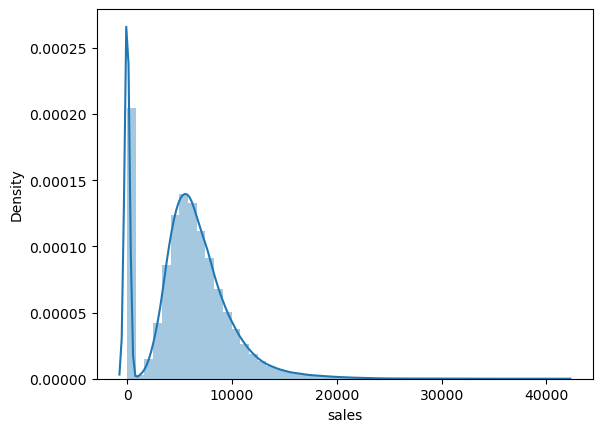

In [28]:
sns.distplot(df1['sales'])

### 1.7.2 Categorical Attributes

In [29]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [30]:
df1['state_holiday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

<Axes: xlabel='assortment', ylabel='sales'>

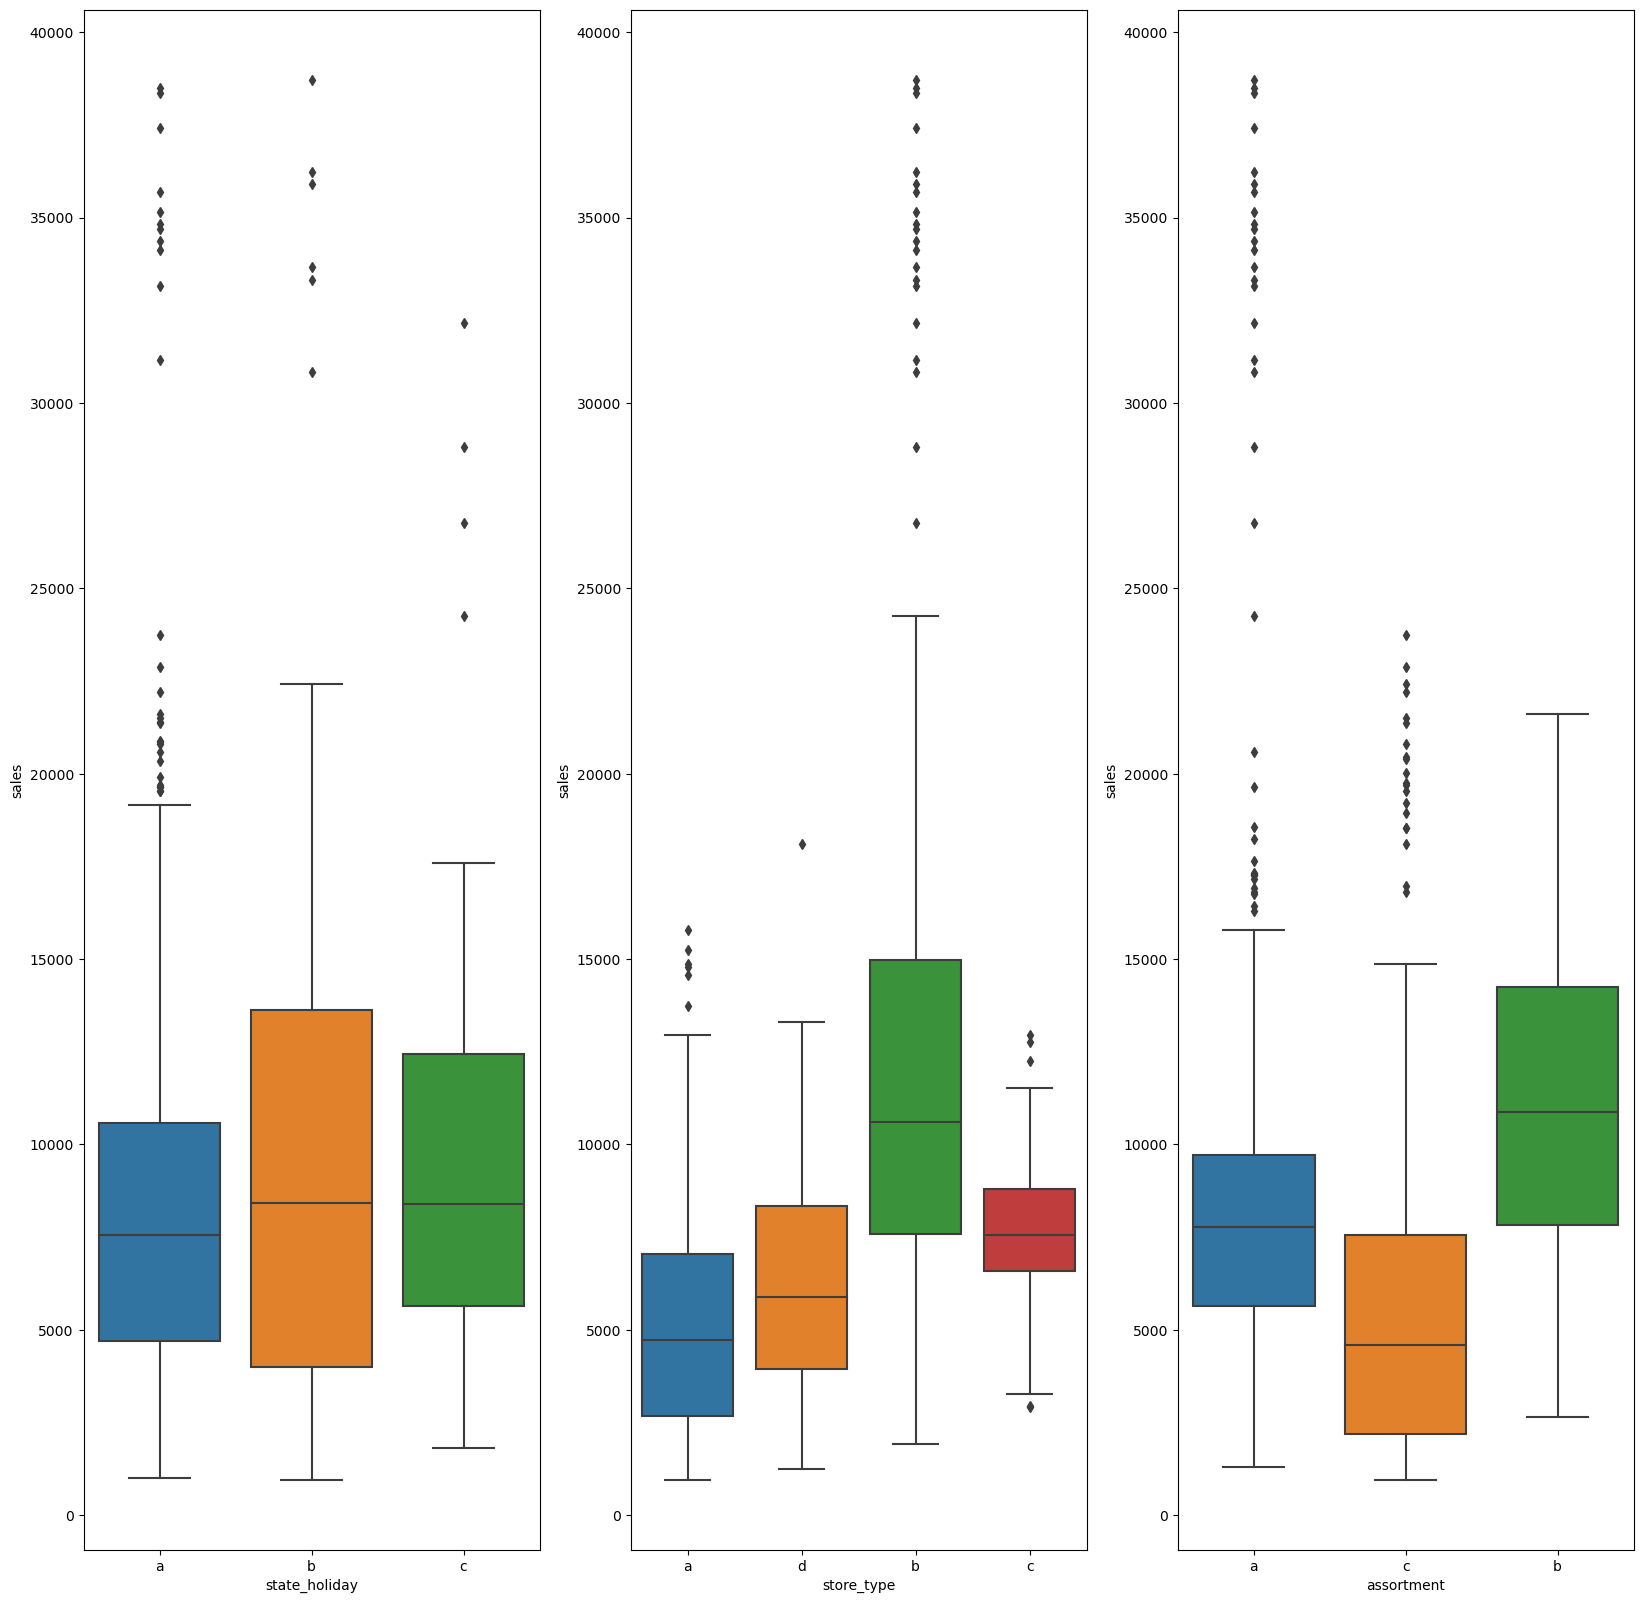

In [31]:
aux = df1[(df1['sales'] > 0 ) & (df1['state_holiday'] != '0')]

plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux)



# 2.0 FEATURE ENGINEERING

In [88]:
df2 = df1.copy()

In [48]:
df2.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
944815,81,3,2013-03-06,6232,515,1,1,0,0,a,a,2370.0,3,2011,1,40,2014,"Jan,Apr,Jul,Oct",Mar,0
625864,20,2,2013-12-17,12849,1169,1,1,0,0,d,a,2340.0,5,2009,1,40,2014,"Jan,Apr,Jul,Oct",Dec,0
509782,1013,2,2014-04-01,5347,544,1,1,0,0,a,a,630.0,2,2015,1,31,2013,"Feb,May,Aug,Nov",Apr,0
58869,890,2,2015-06-09,4793,421,1,0,0,0,a,a,4450.0,6,2015,1,14,2011,"Jan,Apr,Jul,Oct",Jun,0
700194,760,6,2013-10-12,8058,1302,1,0,0,0,a,a,560.0,1,2011,0,41,2013,0,Oct,0


## 2.1 Mapa mental de hipóteses

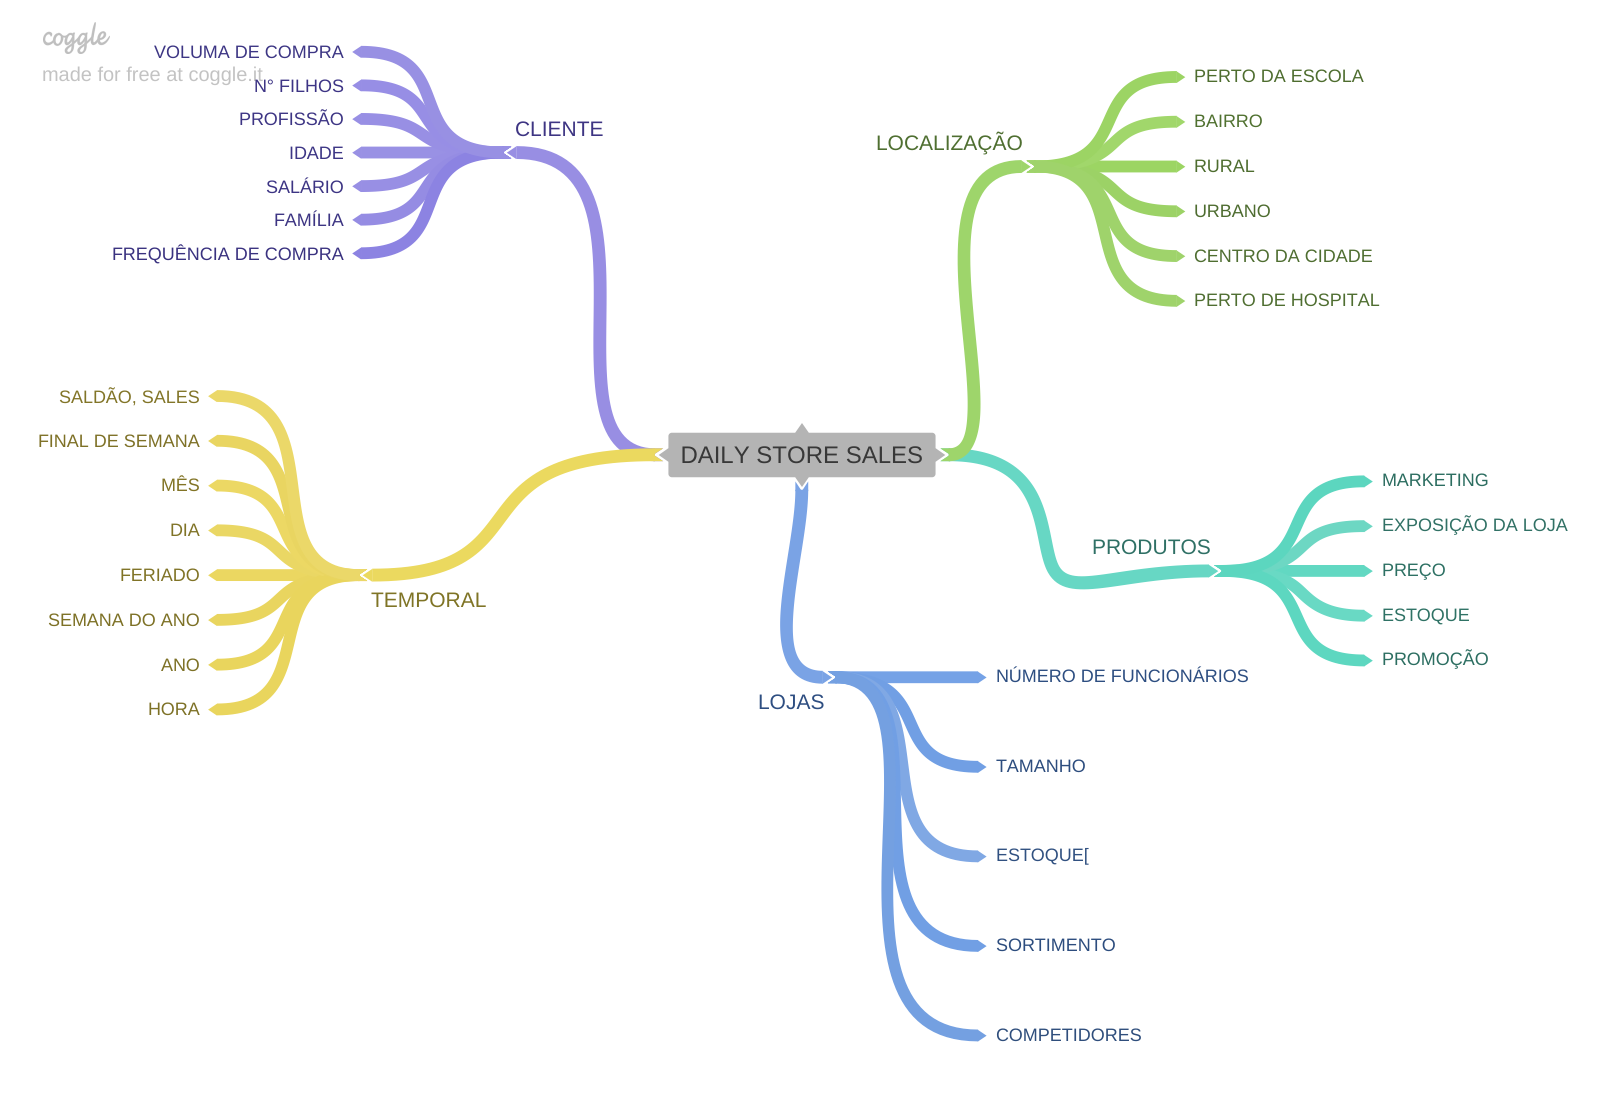

In [37]:
Image('img/mindmap.png')

## 2.2 Criação das HIpóteses

### 2.2.1 Hipóteses Lojas

1. Lojas com número maior de funcionários deveriam vender mais.

2. Lojas com maior capacidade de estoque deveriam vender mais.

3. Lojas com maior porte deveriam vender mais.

4. Lojas com maior sortimentos deveriam vender mais.

5. Lojas com competidores mais próximos deveriam vender menos.

6. Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Hipóteses Produto

1. Lojas que investem mais em Marketing deveriam vender mais.

2. Lojas com maior exposição de produto deveriam vender mais.

3. Lojas com produtos com preço menor deveriam vender mais.

5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

6. Lojas com promoções ativas por mais tempo deveriam vender mais.

7. Lojas com mais dias de promoção deveriam vender mais.

8. Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Temporal

1. Lojas com maior sortimentos deveriam vender mais.

2. Lojas com competidores mais próximos deveriam vender menos.

3. Lojas com competidores à mais tempo deveriam vendem mais.

4. Lojas com promoções ativas por mais tempo deveriam vender mais.


### 2.2.4 Lista final de HIpóteses

1. Lojas com maior sortimentos deveriam vender mais.

2. Lojas com competidores mais próximos deveriam vender menos.

3. Lojas com competidores à mais tempo deveriam vendem mais.

4. Lojas com promoções ativas por mais tempo deveriam vender mais.

5. Lojas com mais dias de promoção deveriam vender mais.

7. Lojas com mais promoções consecutivas deveriam vender mais.

8. Lojas abertas durante o feriado de Natal deveriam vender mais.

9. Lojas deveriam vender mais ao longo dos anos.

10. Lojas deveriam vender mais no segundo semestre do ano.

11. Lojas deveriam vender mais depois do dia 10 de cada mês.

12. Lojas deveriam vender menos aos finais de semana.

13. Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

In [49]:
df2.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
693116,372,5,2013-10-18,8022,763,1,0,0,0,d,c,4880.0,8,2010,1,18,2014,"Jan,Apr,Jul,Oct",Oct,1


In [116]:
#year
df2['year'] = df2['date'].dt.year
#month
df2['month'] = df2['date'].dt.month
#day
df2['day'] = df2['date'].dt.day
#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
#year-week
df2['year_week'] = df2['date'].dt.strftime("%Y-%W")
#competition since

df2['competition_since'] = df2.apply(lambda x : datetime.datetime(year = x['competition_open_since_year'], month=  x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days)

#promo_since
df2['promo_since'] =  df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', "%Y-%W-%w") - datetime.timedelta(days=7))
df2['promo_time_week']=((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)
#assortment

df2['assortment'] = df2['assortment'].apply(lambda x : 'basic' if x == 'a' else  'extra' if x == 'c' else 'extended')

#state_holiday

df2['state_holiday']= df2['state_holiday'].apply(lambda x: 'public holiday' if x =='a' else 'Easter holiday' if x == 'b' else 'Christmas') 


/tmp/ipykernel_24150/2127317508.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [117]:
display(df2.head().T)
display(df2.dtypes)

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,Christmas,Christmas,Christmas,Christmas,Christmas
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        